In [ ]:
from src.extract_data import load_data, process_data
from src.utils import get_test_set
import pandas as pd
from src.constants import FILE_PATH
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import numpy as np 
import seaborn as sns
set_matplotlib_formats('svg')
import tensorflow as tf
import IPython
import IPython.display

from src.utils import build_time_series

In [39]:
def plot_test(x_test, y_test, model = None):
    y_test = y_test.reshape(y_test.shape[0], -1)
    fix, ax = plt.subplots(y_test.shape[1] , 1, figsize=(10,7))
    
    if y_test.shape[1] == 1:
        historical_index = [x for x in range(x_test.shape[0])]
        pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

        ax.plot(historical_index, x_test[:, 0], marker='.', label='Input')
        ax.scatter(pred_index, y_test[:, 0], edgecolors='k', label='Labels', c='#2ca02c', s=32)

        if model is not None:
            preds = model(np.expand_dims(x_test, axis=0))[0]
            ax.scatter(pred_index, preds[:, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            
    else:
        for i in range(y_test.shape[1]):
            historical_index = [x for x in range(x_test.shape[0])]
            pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

            ax[i].plot(historical_index, x_test[:, i], marker='.', label='Input')
            ax[i].scatter(pred_index, y_test[:, i], edgecolors='k', label='Labels', c='#2ca02c', s=32)

            if model is not None:
                preds = model(np.expand_dims(x_test, axis=0))[0]
                ax[i].scatter(pred_index, preds[:, i],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
    plt.legend()

In [64]:
FORECAST_SIZE = 5
WINDOW_SIZE = FORECAST_SIZE * 10
NUM_FEATURES = 1

In [65]:
df = load_data(FILE_PATH)
df = process_data(df, use_covariates=False)

In [66]:
#df = df.drop(['day_of_month', 'month'], axis=1)
df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,18680,1799
2019-03-02,12341,1049
2019-03-03,10839,969
2019-03-04,18502,2228
2019-03-05,18373,1767


In [67]:
n = len(df)
train_df = df[0:int(n*0.7)].astype(float)
val_df = df[int(n*0.7):int(n*0.9)].astype(float)
test_df = df[int(n*0.9):].astype(float)

In [68]:
def normalize(data):
    dic = {}
    for col in ['nbr_travels', 'nbr_late_trains']:
        data_mean = data[col].mean()
        data_std = data[col].std()
        dic[col] = [data_mean, data_std]
    return dic

dic = normalize(train_df)

In [69]:
train_df['nbr_travels'] = (train_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
train_df['nbr_late_trains'] = (train_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

val_df['nbr_travels'] = (val_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
val_df['nbr_late_trains'] = (val_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

test_df['nbr_travels'] = (test_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
test_df['nbr_late_trains'] = (test_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

In [70]:
#train_df = train_df.drop('nbr_late_trains', axis=1)
#val_df = val_df.drop('nbr_late_trains', axis=1)
#test_df = test_df.drop('nbr_late_trains', axis=1)


train_df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,1.256222,0.793774
2019-03-02,-0.239490,-0.356145
2019-03-03,-0.593893,-0.478803
2019-03-04,1.214223,1.451528
2019-03-05,1.183785,0.744711


In [71]:
train_x, train_y = build_time_series(train_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
val_x, val_y = build_time_series(val_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
test_x, test_y = build_time_series(test_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)

train_y = train_y[:, :, 0]
val_y = val_y[:, :, 0]
test_y = test_y[:, :, 0]

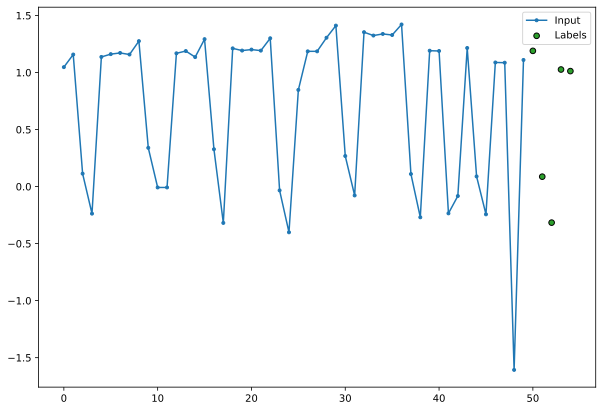

In [72]:
plot_test(test_x[0], test_y[0])

In [73]:
def compile_and_fit(model, max_epochs, train_x, train_y, val_x, val_y, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(train_x, train_y, epochs=max_epochs,
                      validation_data=(val_x, val_y),
                      callbacks=[early_stopping])
    return history

In [74]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(64, return_sequences=False),

    tf.keras.layers.Dense(FORECAST_SIZE*NUM_FEATURES),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([FORECAST_SIZE, NUM_FEATURES])
])

history = compile_and_fit(
    multi_lstm_model,
    500,
    train_x,
    train_y,
    val_x,
    val_y)

#IPython.display.clear_output()

Epoch 1/500
19/19 [==============================] - 2s 43ms/step - loss: 0.7320 - mean_absolute_error: 0.7676 - val_loss: 0.5931 - val_mean_absolute_error: 0.7236
Epoch 2/500
19/19 [==============================] - 0s 24ms/step - loss: 0.5557 - mean_absolute_error: 0.6459 - val_loss: 0.4974 - val_mean_absolute_error: 0.6565
Epoch 3/500
19/19 [==============================] - 0s 22ms/step - loss: 0.5114 - mean_absolute_error: 0.6186 - val_loss: 0.4315 - val_mean_absolute_error: 0.6059
Epoch 4/500
19/19 [==============================] - 0s 26ms/step - loss: 0.4722 - mean_absolute_error: 0.5983 - val_loss: 0.3799 - val_mean_absolute_error: 0.5522
Epoch 5/500
19/19 [==============================] - 0s 22ms/step - loss: 0.4316 - mean_absolute_error: 0.5608 - val_loss: 0.3343 - val_mean_absolute_error: 0.4911
Epoch 6/500
19/19 [==============================] - 0s 24ms/step - loss: 0.3887 - mean_absolute_error: 0.5201 - val_loss: 0.2978 - val_mean_absolute_error: 0.4425
Epoch 7/500
19/1

Epoch 51/500
19/19 [==============================] - 0s 22ms/step - loss: 0.1041 - mean_absolute_error: 0.1910 - val_loss: 0.1198 - val_mean_absolute_error: 0.2059
Epoch 52/500
19/19 [==============================] - 0s 21ms/step - loss: 0.1017 - mean_absolute_error: 0.1869 - val_loss: 0.1253 - val_mean_absolute_error: 0.2135
Epoch 53/500
19/19 [==============================] - 0s 20ms/step - loss: 0.1004 - mean_absolute_error: 0.1851 - val_loss: 0.1225 - val_mean_absolute_error: 0.2172
Epoch 54/500
19/19 [==============================] - 0s 22ms/step - loss: 0.0983 - mean_absolute_error: 0.1837 - val_loss: 0.1192 - val_mean_absolute_error: 0.2072
Epoch 55/500
19/19 [==============================] - 0s 23ms/step - loss: 0.0986 - mean_absolute_error: 0.1830 - val_loss: 0.1232 - val_mean_absolute_error: 0.2221
Epoch 56/500
19/19 [==============================] - 0s 23ms/step - loss: 0.0977 - mean_absolute_error: 0.1787 - val_loss: 0.1229 - val_mean_absolute_error: 0.2131
Epoch 57/5

MAPE : 60.827038 %


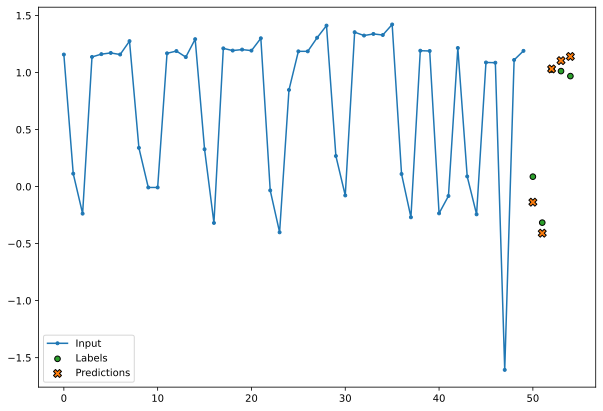

In [78]:
plot_test(test_x[1], test_y[1], model=multi_lstm_model)
preds = multi_lstm_model(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


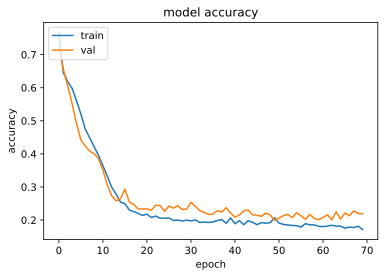

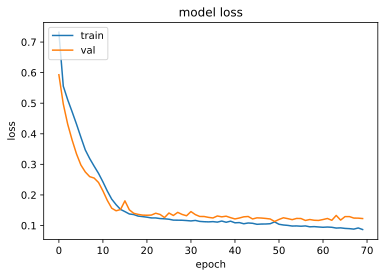

In [76]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(FORECAST_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([FORECAST_SIZE, NUM_FEATURES])
])

history = compile_and_fit(
    multi_conv_model,
    200,
    train_x,
    train_y,
    val_x,
    val_y)

In [ ]:
plot_test(test_x[0], test_y[0], model=multi_conv_model)
preds = multi_conv_model(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()